# Frequent Words

In this notebook, we clean a dataset of sentences and examine those that have the suicide label. Then we find the most frequent words in these labels.

## Main libs

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

## Reading dataset

In this notebook we use /kaggle/input/suicide-watch to test our functions.

In [2]:
import kagglehub
path = kagglehub.dataset_download("nikhileswarkomati/suicide-watch")
filename = "Suicide_Detection.csv"

In [3]:
df = pd.read_csv(f"{path}/{filename}")
df.head()

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


## Plot distribution of classes

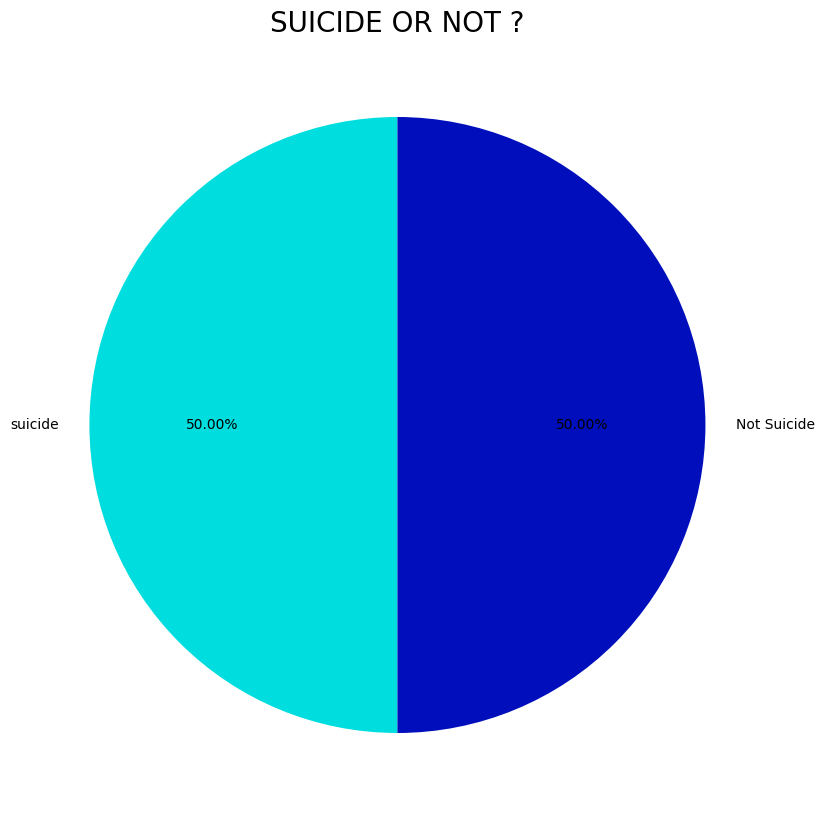

In [4]:
plt.figure(figsize=(12,10))
plt.pie(df['class'].value_counts(),startangle=90,colors=['#00dddf','#000fbb'],
        autopct='%0.2f%%',labels=['suicide','Not Suicide'])
plt.title('SUICIDE OR NOT ?',fontdict={'size':20})
plt.show()

## Loc on suicide labels

In [5]:
df = df[df["class"] == "suicide"]
df.head()

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide
5,11,Honetly idkI dont know what im even doing here...,suicide
6,12,[Trigger warning] Excuse for self inflicted bu...,suicide


## Cleaning dataset

In [6]:
import string
from collections import Counter, defaultdict
import emoji
from bidi.algorithm import get_display
import html
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

def clean_text_basic(text):
    """
    Clean text basic
    """
    if not isinstance(text, str):
        return ""

    text = text.lower()

    # removing special characters (keeping English, Arabic, and Hebrew letters)
    text = re.sub(r'[^\w\s\u0600-\u06FF\u0750-\u077F\u08A0-\u08FF\uFB50-\uFDFF\uFE70-\uFEFF]', ' ', text)

    # removing extra spaces
    text = re.sub(r'\s+', ' ', text)

    # Remove spaces from the beginning and end
    text = text.strip()

    # Handle stop words - FIXED: text is a string, not a Series
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    text = ' '.join(filtered_words)

    return text


    return text

def normalize_persian_text(text):
    """
    Normaliation
    """
    # Nrmalize spaces and half-spaces(specialyy in persian texts)
    text = re.sub(r'[‌\u200c]', ' ', text)  # hlf-space -> normal space


    # Standardization of Persian letters
    text = text.replace('ي', 'ی')
    text = text.replace('ك', 'ک')
    text = text.replace('ة', 'ه')

    # حذف اعراب
    text = re.sub(r'[\u064B-\u065F]', '', text)  # Removing vowels
    return text

def remove_extra_whitespace(text):
    """
    Remove extra spaces
    """
    text = re.sub(r'\s+', ' ', text)  # Replacing multiple spaces with a single space
    text = re.sub(r'^\s+|\s+$', '', text)  # Remove spaces from the beginning and end
    return text

def remove_html_tags(text):
    """
    Removing html tags
    """
    return re.sub(r'<[^>]+>', '', text)

def remove_urls(text):
    """
    Removing urls
    """
    return re.sub(r'http\S+|www\.\S+', '', text)

def remove_emails(text):
    """
    Removing E-mails
    """
    return re.sub(r'\S+@\S+', '', text)

def remove_mentions_hashtags(text):
    """
    Removing mentions and hashtags
    """
    text = re.sub(r'@\w+', '', text)  # حذف mentions
    text = re.sub(r'#\w+', '', text)  # حذف hashtags
    return text

def remove_numbers(text, replace_with=''):
    """
    Replacing numbers
    """
    return re.sub(r'\d+', replace_with, text)

def remove_emoji(text):
    """
    Removing Emojies
    """
    return emoji.replace_emoji(text, replace='')

def correct_persian_spacing(text):
    """
    Correcting spacing in Persian text
    """
    # حرف اضافه‌های فارسی که باید به کلمه قبل بچسبند
    attached_prefixes = ['از', 'به', 'در', 'با', 'بر', 'برای', 'تا', 'بی', 'غیر']

    # حروف ربط که باید به کلمه بعد بچسبند
    attached_suffixes = ['ها', 'های', 'ترین', 'تری', 'ام', 'ات', 'اش']

    words = text.split()
    corrected_words = []

    for i, word in enumerate(words):
        if i > 0 and any(word.startswith(prefix) for prefix in attached_prefixes):
            corrected_words[-1] = corrected_words[-1] + ' ' + word
        elif i < len(words) - 1 and any(words[i+1].startswith(suffix) for suffix in attached_suffixes):
            corrected_words.append(word + ' ' + words[i+1])
        else:
            corrected_words.append(word)

    return ' '.join(corrected_words)

def advanced_text_cleaning(text, cleaning_options=None):
    """
    Advanced text cleaning with configurable options
    """
    if cleaning_options is None:
        cleaning_options = {
            'remove_html': True,
            'remove_urls': True,
            'remove_emails': True,
            'remove_mentions_hashtags': True,
            'remove_numbers': True,
            'remove_emoji': True,
            'normalize_persian': True,
            'correct_spacing': True,
            'remove_extra_whitespace': True
        }

    if not isinstance(text, str):
        return ""

    # Apply cleaning steps based on options
    if cleaning_options.get('remove_html', True):
        text = remove_html_tags(text)

    if cleaning_options.get('remove_urls', True):
        text = remove_urls(text)

    if cleaning_options.get('remove_emails', True):
        text = remove_emails(text)

    if cleaning_options.get('remove_mentions_hashtags', True):
        text = remove_mentions_hashtags(text)

    if cleaning_options.get('remove_numbers', True):
        text = remove_numbers(text)

    if cleaning_options.get('remove_emoji', True):
        text = remove_emoji(text)

    # Base cleaning
    text = clean_text_basic(text)

    if cleaning_options.get('normalize_persian', True):
        text = normalize_persian_text(text)

    if cleaning_options.get('correct_spacing', True):
        text = correct_persian_spacing(text)

    if cleaning_options.get('remove_extra_whitespace', True):
        text = remove_extra_whitespace(text)

    return text

# تابع اصلی برای پاکسازی و ارزیابی
def clean_and_evaluate_dataset(df, text_column, label_column, cleaning_options=None):

    print("Cleaning is started")

    df_clean = df.copy()

    df_clean['original_text'] = df_clean[text_column]

    df_clean['cleaned_text'] = df_clean[text_column].apply(
        lambda x: advanced_text_cleaning(x, cleaning_options)
    )

    original_lengths = df_clean['original_text'].str.len()
    cleaned_lengths = df_clean['cleaned_text'].str.len()

    print(f"Numbe of samples: {len(df_clean)}")
    print(f"Mean length of texts: {original_lengths.mean():.2f}")
    print(f"Mean length of cleaned texts: {cleaned_lengths.mean():.2f}")
    print(f"diff: {(cleaned_lengths.mean() - original_lengths.mean()):.2f}")

    print("\nSample of cleaning:")
    print("Orginal text:", df_clean['original_text'].iloc[0][:100] + "...")
    print("Cleaned text:", df_clean['cleaned_text'].iloc[0][:100] + "...")

    return df_clean


In [7]:
if __name__ == "__main__":
    df = df

    cleaning_config = {
      'remove_html': True,
      'remove_urls': True,
      'remove_emails': True,
      'remove_mentions_hashtags': False,
      'remove_numbers': False,
      'remove_emoji': False,
      'normalize_persian': False,
      'correct_spacing': True,
      'remove_extra_whitespace': True
    }

    # cleaning
    df_cleaned = clean_and_evaluate_dataset(
        df=df,
        text_column='text',
        label_column='class',
        cleaning_options=cleaning_config
    )


Cleaning is started
Numbe of samples: 116037
Mean length of texts: 1050.06
Mean length of cleaned texts: 593.84
diff: -456.22

Sample of cleaning:
Orginal text: Ex Wife Threatening SuicideRecently I left my wife for good because she has cheated on me twice and ...
Cleaned text: ex wife threatening suiciderecently left wife good cheated twice lied much decided refuse go back da...


In [8]:
df_cleaned.head()

,Unnamed: 0,text,class,original_text,cleaned_text
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide,Ex Wife Threatening SuicideRecently I left my ...,ex wife threatening suiciderecently left wife ...
3,8,i need helpjust help me im crying so hard,suicide,i need helpjust help me im crying so hard,need helpjust help im crying hard
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide,"I’m so lostHello, my name is Adam (16) and I’v...",losthello name adam 16 struggling years afraid...
5,11,Honetly idkI dont know what im even doing here...,suicide,Honetly idkI dont know what im even doing here...,honetly idki dont know im even feel like nothi...
6,12,[Trigger warning] Excuse for self inflicted bu...,suicide,[Trigger warning] Excuse for self inflicted bu...,trigger warning excuse self inflicted burns kn...


## Calculate frequency of words

In [9]:
from collections import Counter

# Split text into words and flatten
words = (
    df_cleaned["cleaned_text"]
    .str.split()
    .explode()
)

# Count word frequencies
word_freq = Counter(words)

## Top 20 words

In [10]:
top_20_words = word_freq.most_common(20)
print(top_20_words)

[('like', 131636), ('want', 128364), ('life', 113040), ('feel', 108125), ('know', 106737), ('get', 86428), ('even', 77226), ('people', 73092), ('time', 70862), ('would', 70526), ('one', 69441), ('really', 65168), ('think', 57520), ('going', 57406), ('never', 57007), ('go', 54144), ('much', 50909), ('friends', 48644), ('help', 46795), ('years', 46315)]


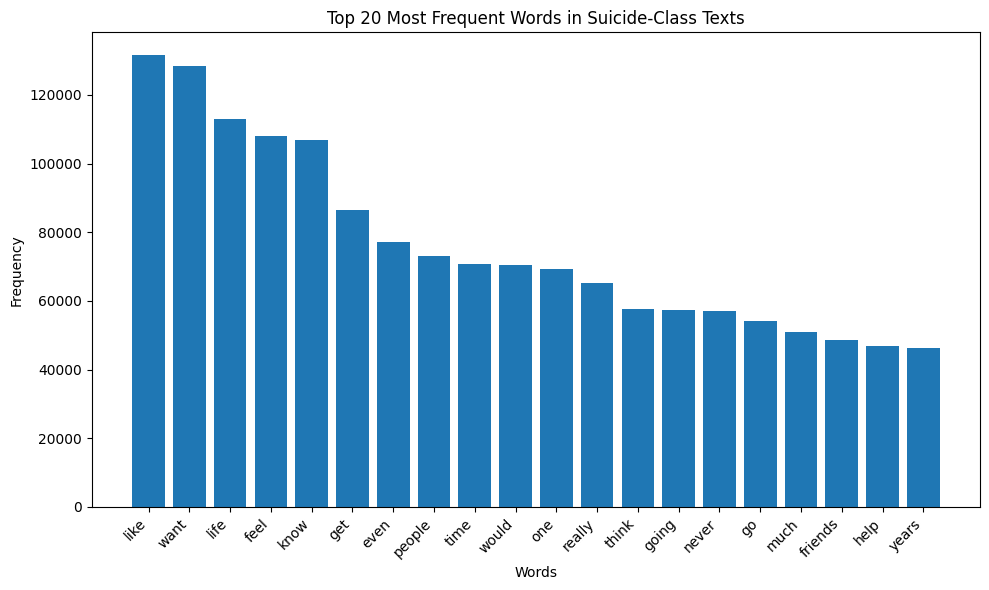

In [11]:
# Separate words and frequencies
labels, counts = zip(*top_20_words)

plt.figure(figsize=(10, 6))
plt.bar(labels, counts)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Top 20 Most Frequent Words in Suicide-Class Texts")
plt.tight_layout()
plt.show()
